# D&D Encounter Difficulty Calibration
## Evaluating the Data
**T. J. Johnson**

---

The goal of this notebook is to investigate the simulated outcomes from generating 10,000 battles of each of the possible encounter difficulties ('easy', 'medium', 'hard', and 'deadly').  The results were generated in the _Generate\_CSVs_ notebook, and represent the outcomes of battles between five first level player characters (PCs) and generic enemies, with challenge ratings between 0 and 3, in combinations which result in a total number of experience points within the bounds of the given encounter difficulty.  For more details on the simple simulation approach, see the repo README.  It is important that all of the results in this notebook be understood in light of the assumptions and simplifications we have made.

The notebook to generate the data also showed a quick look at the CSV file for 'easy' encounters.  We did a similar verification for the other encounters, not shown here, to convince ourselves that the output appears to be in line with what we expect.  While we will explore several aspects of the data, we will not cover every possible way to look at the data.

We will start by loading in the CSV files.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mplcyberpunk
import pandas as pd
import seaborn as sns

In [2]:
#working assumption is that the CSV files are in the current directory
easy_df=pd.read_csv('Simulated_easy_10000battles.csv')
medium_df=pd.read_csv('Simulated_medium_10000battles.csv')
hard_df=pd.read_csv('Simulated_hard_10000battles.csv')
deadly_df=pd.read_csv('Simulated_deadly_10000battles.csv')

### Success or Failure

Perhaps the most straightforward way to evaluate "what does each difficulty rating mean" is to look at the expected percentage of encounters won or lost by the PCs.  Note, the simulation does not take into account death saving throws, instant kills, or the possibility that the PCs might choose to flee (and might be successful in doing so).

In [3]:
all_df=pd.concat([pd.concat([easy_df,
                              pd.DataFrame({'difficulty':['easy']*10000})],axis=1),
                   pd.concat([medium_df,
                              pd.DataFrame({'difficulty':['medium']*10000})],axis=1),
                   pd.concat([hard_df,
                              pd.DataFrame({'difficulty':['hard']*10000})],axis=1),
                   pd.concat([deadly_df,
                              pd.DataFrame({'difficulty':['deadly']*10000})],axis=1)]).reset_index(drop=True)

all_df.success=all_df.success.apply(lambda s: 'Win' if s else 'Lose').astype('category')

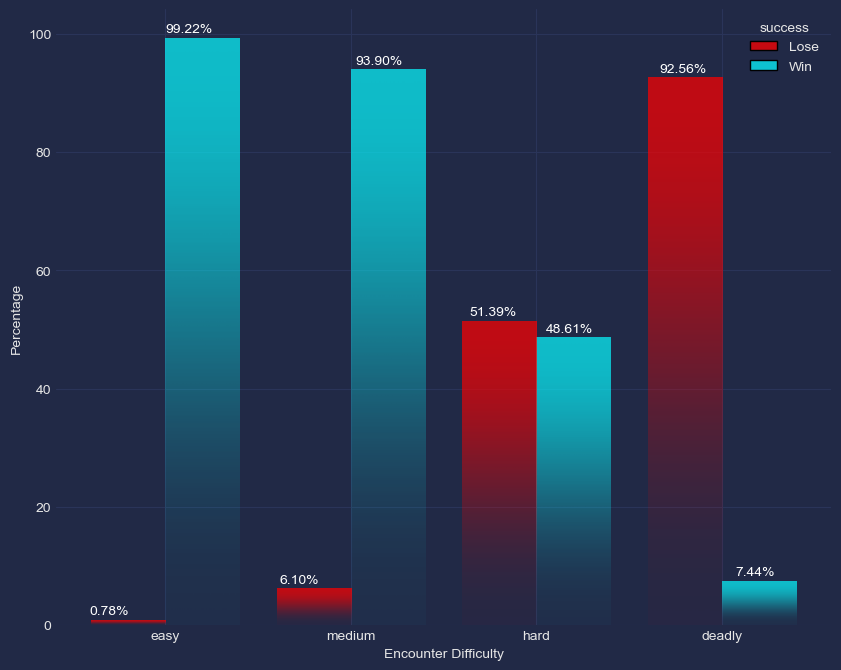

In [58]:
with plt.style.context('cyberpunk'):
    fig,ax=plt.subplots()
    fig.set_size_inches(10,8)
    ax=sns.histplot(x='difficulty',hue='success',data=all_df,multiple='dodge',shrink=0.8,
           ax=ax,palette=['C4','C0'],stat='count',weights=1/100,common_norm=False,hue_order=['Lose','Win'])
    ax.set_xlabel('Encounter Difficulty')
    ax.set_ylabel('Percentage')
    
    #get fractions for percentages to add to plot
    percentages=[]
    percentages+=(easy_df.groupby('success').CRs.count()/10000).to_list()
    percentages+=(medium_df.groupby('success').CRs.count()/10000).to_list()
    percentages+=(hard_df.groupby('success').CRs.count()/10000).to_list()
    percentages+=(deadly_df.groupby('success').CRs.count()/10000).to_list()
    
    #due to how the patches are done when using a variable for hue
    #need to reorder percentages
    percentages=percentages[1:9:2]+percentages[0:8:2]
    
    for patch,percent in zip(ax.patches,percentages):
        ax.annotate(f'{percent:.2%}',xy=(patch.get_x()*1.025,patch.get_height()+1),
                   color='white')
    
    mplcyberpunk.add_bar_gradient(bars=ax.patches)
    
    plt.savefig('plots/SuccessBarPlot_ByDifficulty_Percentages.png')
    
     plt.show()

The results above aren't that surprising, with the win percentage getting lower as the difficulty increases.  In part, this may be due to the fixed rate at which the PCs use their "extras" (e.g., spell slots).  For a first pass, we assume a rate of 10% to use extras for increased damage, with a varying damage dealt to party threshold for using an extra to heal.  This might seem reasonable for a party thinking about conserving resources in the long term for an easy or medium difficulty encounter, but for hard and deadly, the PCs are likely to go for big damage early.  Creating logic for a variable rate at which extras is a future task after additional feedback is received.

This plot would suggest that the PCs should almost always run from a deadly encounter, but one wonders if we can dig deeper into the details of the encounters when they win or lose.  The rating system is open-ended for deadly, so we chose to cap deadly encounters at 3 times the minimum XP level and once we were above the minimum, there's always a 50% chance of stopping, if we didn't provide a limit on the number of enemies.

Let's dig more deeply into this question.

In [5]:
all_df.query('difficulty=="deadly"').groupby('success').num_enemies.value_counts().unstack()

num_enemies,1,2,3,4,5,6,7,8,9,10,11,12,14
success,,,,,,,,,,,,,
Lose,714.0,2429.0,1826.0,1642.0,1043.0,1019.0,301.0,157.0,61.0,47.0,13.0,3.0,1.0
Win,15.0,376.0,250.0,59.0,23.0,5.0,14.0,2.0,NaN,NaN,NaN,NaN,NaN


With 2 or 3 enemies, the win percentage is about 15% (only comparing to encounters with the same number of enemies).  For the other encounters, it is less than a few percent (and generally much less than that).

This hilights one likely issue with our simplifications.  If we have one enemy in a deadly encounter, the average damage is 23.5 (which gets rounded), enough to instakill a level 1 PC.  However, with our current simulation this total damage will be deducted from the total party hit points, which is actually subtracting too much if it is a single target attack (e.g., if this hit and took out a PC with 8 hit points, the total party hit points should be reduced by 8, not 23).  With more enemies, the average damage gets lowered, somewhat alleviating this issue.

In the future, we may deal with this in a more consistent/realistic manner.  However, we will still proceed under the assumption that we can evaluate the amount of resources required, on average, to win an encounter and use this to decide what implications there are for how much the party can handle after such an encounter.  The results may be more applicable to the lesser difficulties.

### Effect on Party Resources

The 'Win' or 'Lose' outcome may be the easiest metric to interpret, but it is also, perhaps, the least informative.  It would not be surprising that the party could be expected to prevail in an 'easy' or 'medium' encounter, starting with full health and all other resources, but how will that encounter affect their prospects for future encounters?  This is particularly important if the party is going into a dungeon crawl or other scenario with the prospect for multiple encounters.

What do we mean by resources?  For these simulations, we mean how much of the party total hit points and how many of the limited-use extras were used.  The extras can be thought of as resources such as spell slots and other limited-use abilities (e.g., a paladin's Lay on Hands).  Magic items with charges and healing potions would also fit into our definition of resources, but first level characters are unlikely to have access to these resources so, as discussed in the README, we do not factor that into the possible 'extras' of the party.  Future code enhancements, particularly as we consider how generalizable these results are to higher character levels, will attempt to account for those items.

To begin, we'll select just the encounters were the party was successful.  While it might be interesting to consider resources spent for the encounters the party lost, with the goal of "If the party fled these encounters, how much might they have lost?", we will save that question for a future analysis.

In [6]:
#make sure to copy in case we make changes
wins_df=all_df.query('success=="Win"').copy()

#we'll make a list of the resource columns
resources=['party_hp','party_extras','frac_party_hp',
           'frac_party_extras']

#and let's set some display options
pd.set_option('display.precision',3)

wins_df[resources].describe()

,party_hp,party_extras,frac_party_hp,frac_party_extras
count,24917.000,24917.000,24917.000,24917.000
mean,23.670,2.515,0.564,0.503
std,10.437,1.689,0.249,0.338
min,1.000,0.000,0.024,0.000
25%,16.000,1.000,0.381,0.200
50%,23.000,3.000,0.548,0.600
75%,30.000,4.000,0.714,0.800
max,42.000,5.000,1.000,1.000


There's clearly a large range for each of these resource columns.  It likely makes more sense to look at the statistics split by encounter difficulty.  This done below, but it is a bit cumbersome, note the need to scroll horizontally.

In [7]:
pd.set_option('display.max_columns',None)
wins_df.groupby('difficulty',sort=False)[resources].describe()

party_hp                                             party_extras  \
              count    mean    std  min   25%   50%   75%   max        count   
difficulty                                                                     
easy         9922.0  32.016  8.320  4.0  26.0  34.0  40.0  42.0       9922.0   
medium       9390.0  20.850  6.955  1.0  16.0  23.0  26.0  42.0       9390.0   
hard         4861.0  13.868  6.465  1.0   9.0  14.0  17.0  42.0       4861.0   
deadly        744.0  11.988  6.922  1.0   7.0  12.0  16.0  33.0        744.0   

                                                  frac_party_hp                \
             mean    std  min  25%  50%  75%  max         count   mean    std   
difficulty                                                                      
easy        3.849  1.188  0.0  3.0  4.0  5.0  5.0        9922.0  0.762  0.198   
medium      1.999  1.353  0.0  1.0  2.0  3.0  5.0        9390.0  0.496  0.166   
hard        1.061  1.151  0.0  0.0  1.0  2.0  5.0        4861.0  0.330  0.154   
deadly      0.724  0.933  0.0  0.0  0.0  1.0  4.0         744.0  0.285  0.165   

                                              frac_party_extras                \
              min    25%    50%    75%    max             count   mean    std   
difficulty                                                                      
easy        0.095  0.619  0.810  0.952  1.000            9922.0  0.770  0.238   
medium      0.024  0.381  0.548  0.619  1.000            9390.0  0.400  0.271   
hard        0.024  0.214  0.333  0.405  1.000            4861.0  0.212  0.230   
deadly      0.024  0.167  0.286  0.381  0.786             744.0  0.145  0.187   

                                     
            min  25%  50%  75%  max  
difficulty                           
easy        0.0  0.6  0.8  1.0  1.0  
medium      0.0  0.2  0.4  0.6  1.0  
hard        0.0  0.0  0.2  0.4  1.0  
deadly      0.0  0.0  0.0  0.2  0.8

With the output above, we can note a few things.  For all but the deadly encounters, the party is sometimes able to win with full hit points and/or full extras.  As expected, the mean and median (50$^{th}$ percentile) values decrease as the difficulty increases.  For medium - deadly encounters, there are some cases where the party wins with only 1 HP (suggesting only 1 PC was left standing).  The inter-quartile ranges can be deduced from the values, but to get a better feel for the variation we might expect, let's look at the 90% interval, which lends itself to a nice "nine times out of ten" simplistic interpretation.

For instance, nine times out of ten, we expect the party to lose no more than $\approx$ (100-38) = 62% of their total hit points during an easy encounter that they win.
In contrast, for even a medium encounter we expect that, nine times out of ten, they will lose between $\approx$ 29 - 81 % of their total hit points.  The amount lost, for an encounter the party wins, continues to increase with difficulty.

In [8]:
wins_df.groupby('difficulty',sort=False)[resources].quantile([0.05,0.95])

party_hp  party_extras  frac_party_hp  frac_party_extras
difficulty                                                               
easy       0.05      16.0           2.0          0.381                0.4
           0.95      42.0           5.0          1.000                1.0
medium     0.05       8.0           0.0          0.190                0.0
           0.95      30.0           4.0          0.714                0.8
hard       0.05       3.0           0.0          0.071                0.0
           0.95      26.0           3.0          0.619                0.6
deadly     0.05       2.0           0.0          0.048                0.0
           0.95      25.0           3.0          0.595                0.6

Let's examine these distributions graphically.  To attempt to generalize this away from the specific average hit point per PC and starting, maximum number of extras, we'll use the fractional values the _frac_ columns.  More specifically, we'll use 1 - these values to look at fraction spent instead of fraction remaining.

For the extras, we start with 5, so steps of 0.2 when binning is an easy choice.  For the hit points, using an average hit point value per PC of 8.5 (see the README) and rounding (note, numpy.round rounds down for #.5) we get a total party hit point value of 42 for five PCs.  Hit points are deducted or added in integer increments.  For starters, 14 points was tried, but this proved to be more susceptible to fluctuations, so we settled on 7.

In [9]:
HP_cut=pd.cut(1-wins_df.frac_party_hp,np.linspace(-1/7,1+1/7,9),include_lowest=True)
Ex_cut=pd.cut(1-wins_df.frac_party_extras,np.linspace(-0.1,1.1,7),include_lowest=True)

In [10]:
cuts_wins_df=pd.concat([wins_df,
                   pd.DataFrame({'HP_cut':HP_cut,
                                 'Ex_cut':Ex_cut},index=wins_df.index)],
                   axis=1)

In [11]:
HP_frac=cuts_wins_df.pivot_table('frac_party_hp','HP_cut','difficulty',
                    aggfunc='count',fill_value=0)

Ex_frac=cuts_wins_df.pivot_table('frac_party_extras','Ex_cut','difficulty',
                    aggfunc='count',fill_value=0)

In [12]:
HP_cent=np.array([0+idx*1/7 for idx in range(8)])
Ex_cent=np.array([0+0.2*idx for idx in range(6)])

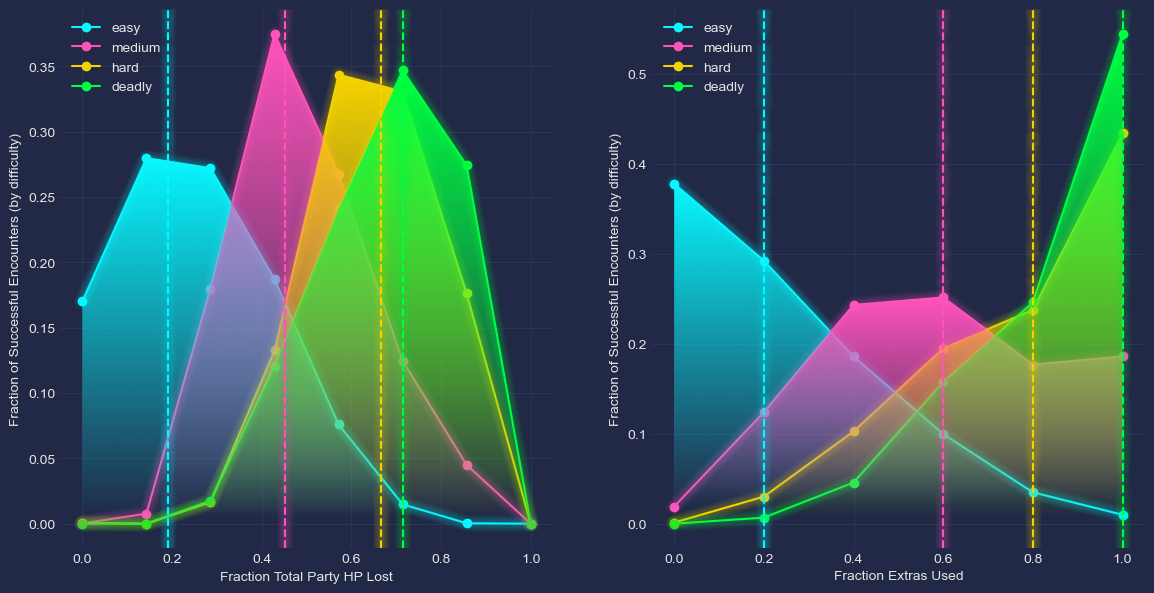

In [13]:
difficulties=['easy','medium','hard','deadly']
colors=['C0','C1','C2','C3']
with plt.style.context('cyberpunk'):
    fig,ax=plt.subplots(nrows=1,ncols=2)
    
    fig.set_size_inches(h=7,w=14)
    
    for difficulty in difficulties:
        ax[0].plot(HP_cent,HP_frac[[difficulty]]/HP_frac[[difficulty]].sum(),
                   marker='o',ms=6,label=difficulty)
        
        ax[1].plot(Ex_cent,Ex_frac[[difficulty]]/Ex_frac[[difficulty]].sum(),
                   marker='o',ms=6,label=difficulty)

    ax[0].legend(loc='upper left')
    ax[1].legend(loc='upper left')
    
    mplcyberpunk.add_glow_effects(gradient_fill=True,ax=ax[0])
    
    mplcyberpunk.add_glow_effects(gradient_fill=True,ax=ax[1])
    
    for difficulty,color in zip(difficulties,colors):
        vline=ax[0].axvline(1-wins_df.query(f'difficulty=="{difficulty}"').frac_party_hp.median(),
                     color=color,linestyle='dashed')
        mplcyberpunk.make_lines_glow(lines=vline)
        
        vline=ax[1].axvline(1-wins_df.query(f'difficulty=="{difficulty}"').frac_party_extras.median(),
                     color=color,linestyle='dashed')
        mplcyberpunk.make_lines_glow(lines=vline)
    
    ax[0].set_xlabel('Fraction Total Party HP Lost')
    ax[1].set_xlabel('Fraction Extras Used')
    
    ax[0].set_ylabel('Fraction of Successful Encounters (by difficulty)')
    ax[1].set_ylabel('Fraction of Successful Encounters (by difficulty)')
    
    plt.savefig('plots/FracResourcesUsed_ByDifficulty_all.png')
    
    plt.show()

The plots above paint an interesting picture regarding how much a given difficulty encounter is expected to eat into party resources.  It is interesting to note that there is less distinction between hard and deadly encounters than for the other difficulty ratings.  This suggests that hard encounters really do stretch the limits of what the party can do, and deadly encounters push them beyond that leading to a much lower Win rate.

These plots are useful to compare the difficulties (and ensure that the trends we see make sense with what we naively expect) but it is difficult to visualize the expected range of resource usage.  While we calculated the 90% intervals previously, combining the numbers with the visuals should have more of an impact.  The plots above are too crowded for that, so we will make some 4-panel plots below.

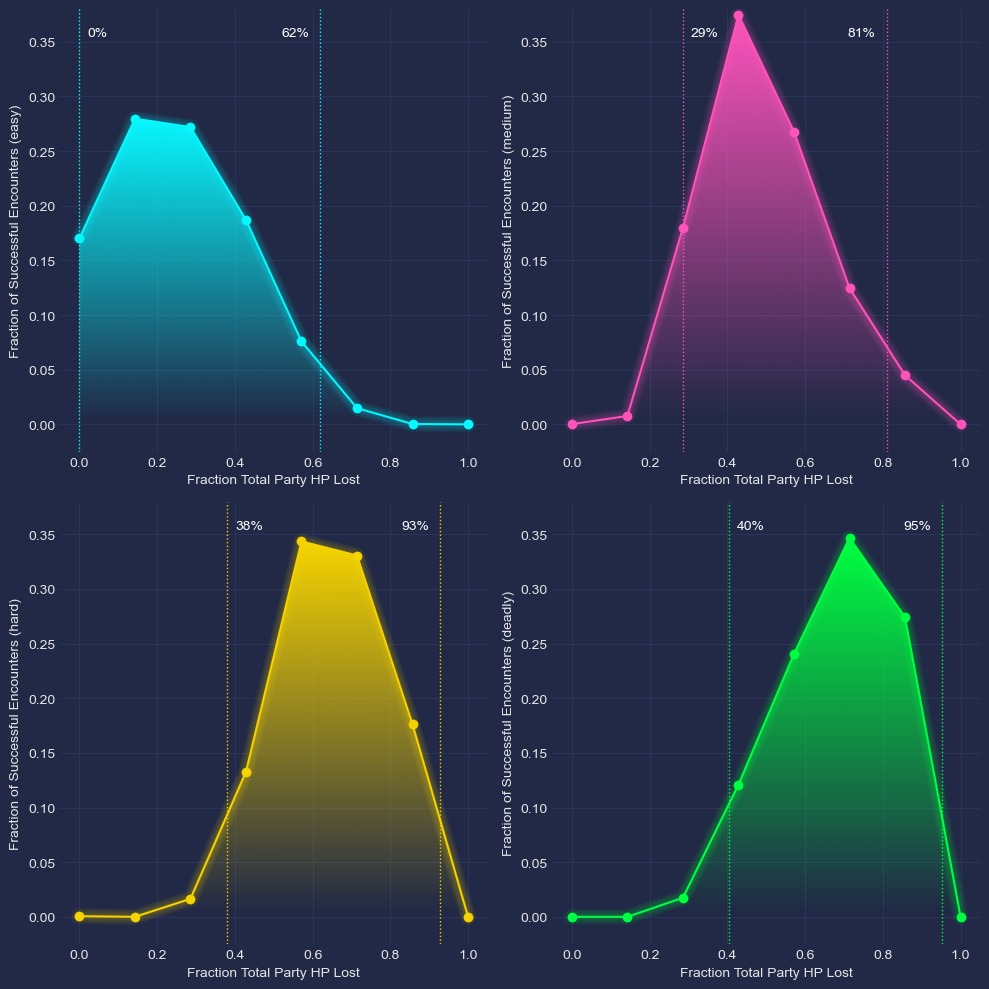

In [14]:
#first, we'll look at the HP fraction
with plt.style.context('cyberpunk'):
    fig,ax=plt.subplots(nrows=2,ncols=2)
    
    fig.set_size_inches(10,10)
    
    ax=ax.ravel()
    
    for idx in range(4):
        #ax[idx].set_title(difficulties[idx])
        ax[idx].plot(HP_cent,HP_frac[[difficulties[idx]]]/HP_frac[[difficulties[idx]]].sum(),
                   marker='o',ms=6,color=colors[idx])
        
        mplcyberpunk.add_glow_effects(gradient_fill=True,ax=ax[idx])
        
        ax[idx].set_ylim(-0.025,0.38)
        
        pt05,pt95=1-wins_df.query(f'difficulty=="{difficulties[idx]}"').frac_party_hp.quantile([0.05,0.95])
        
        ax[idx].vlines([pt05,pt95],ymin=-0.025,ymax=0.38,
                        colors=colors[idx],linestyles='dotted',linewidths=1.)
        
        ax[idx].annotate(f'{pt05:.0%}',xy=(pt05-0.1,ax[idx].get_ylim()[1]-0.025),
                         color='white')
        
        ax[idx].annotate(f'{pt95:.0%}',xy=(pt95+0.02,ax[idx].get_ylim()[1]-0.025),
                         color='white')
        
        ax[idx].set_xlabel('Fraction Total Party HP Lost')
    
        ax[idx].set_ylabel(f'Fraction of Successful Encounters ({difficulties[idx]})')
    
    plt.tight_layout()
    
    plt.savefig('plots/FracHPLost_ByDifficulty_4Panel.png')
    
    plt.show()


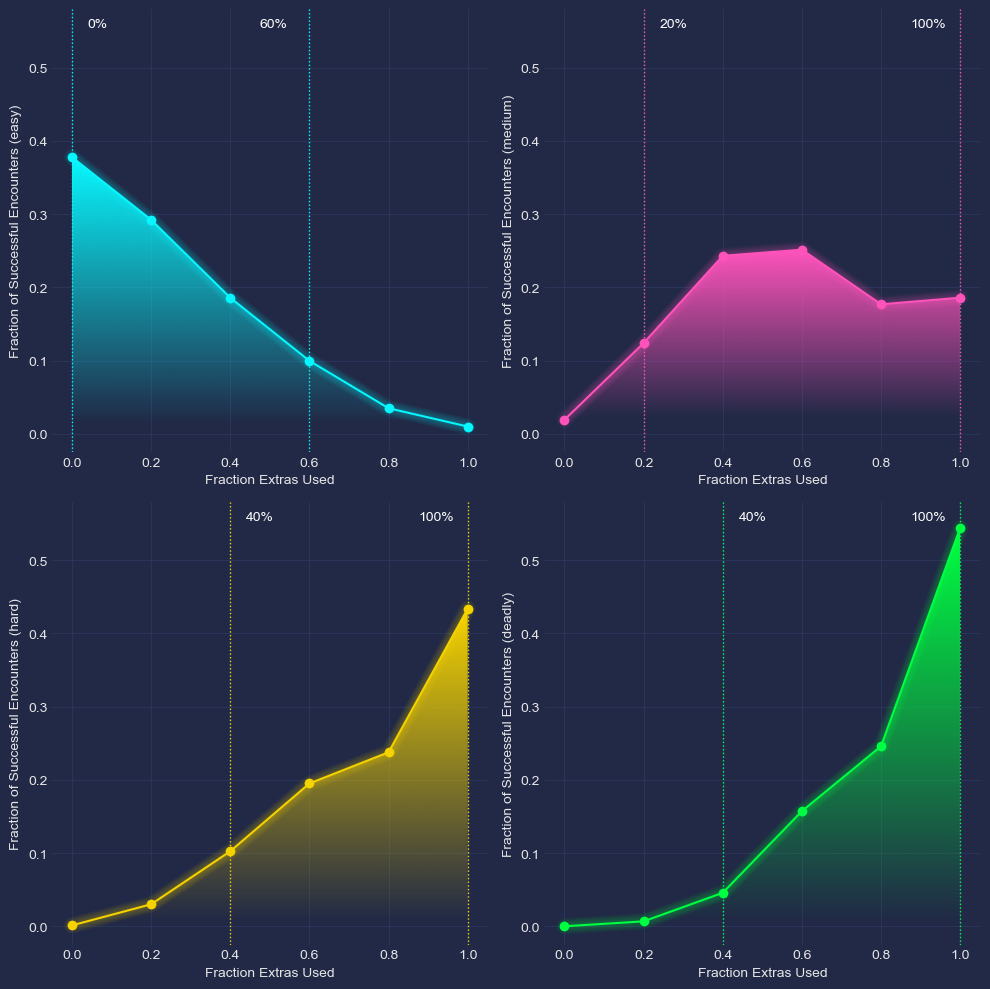

In [15]:
#first, we'll look at the HP fraction
with plt.style.context('cyberpunk'):
    fig,ax=plt.subplots(nrows=2,ncols=2)
    
    fig.set_size_inches(10,10)
    
    ax=ax.ravel()
    
    for idx in range(4):
        #ax[idx].set_title(difficulties[idx])
        ax[idx].plot(Ex_cent,Ex_frac[[difficulties[idx]]]/Ex_frac[[difficulties[idx]]].sum(),
                   marker='o',ms=6,color=colors[idx])
        
        mplcyberpunk.add_glow_effects(gradient_fill=True,ax=ax[idx])
        
        ax[idx].set_ylim(-0.025,0.58)
        
        pt05,pt95=1-wins_df.query(f'difficulty=="{difficulties[idx]}"').frac_party_extras.quantile([0.05,0.95])
        
        ax[idx].vlines([pt05,pt95],ymin=-0.025,ymax=0.58,
                        colors=colors[idx],linestyles='dotted',linewidths=1.)
        
        ax[idx].annotate(f'{pt05:.0%}',xy=(pt05-0.125,ax[idx].get_ylim()[1]-0.025),
                         color='white')
        
        ax[idx].annotate(f'{pt95:.0%}',xy=(pt95+0.04,ax[idx].get_ylim()[1]-0.025),
                         color='white')
        
        ax[idx].set_xlabel('Fraction Extras Used')
    
        ax[idx].set_ylabel(f'Fraction of Successful Encounters ({difficulties[idx]})')
    
    plt.tight_layout()
    
    plt.savefig('plots/FracExtrasUsed_ByDifficulty_4Panel.png')
    
    plt.show()

The multi-panel plots are a bit easier to understand, and while the median is a helpful statistic, for these purposes that 90% interval is more informative.  However, there is one nagging question as far as the use of resources is concerned.  Do the use of extras and the amount of lost HP track each other?  If they do, in what manner?

As the party takes damage, extras are used to heal which means the fraction of total hit points lost decreases.  Additionally, extras can be used for increased damage (though these don't always hit), so if they are used the encounter may end quicker with fewer hit points lost by the party.  At some point, however, in a drawn out (or tough) encounter, the extras are used up and the party will continue to lose hit points.  This might mean that the correlation between the loss of these two resources depends on the encounter difficulty and how long the encounter takes (e.g., more enemies).

We'll investigate this question with some scatter plots.  We'll use the same color coding but also let the size of the marker be linked to the number of enemies.

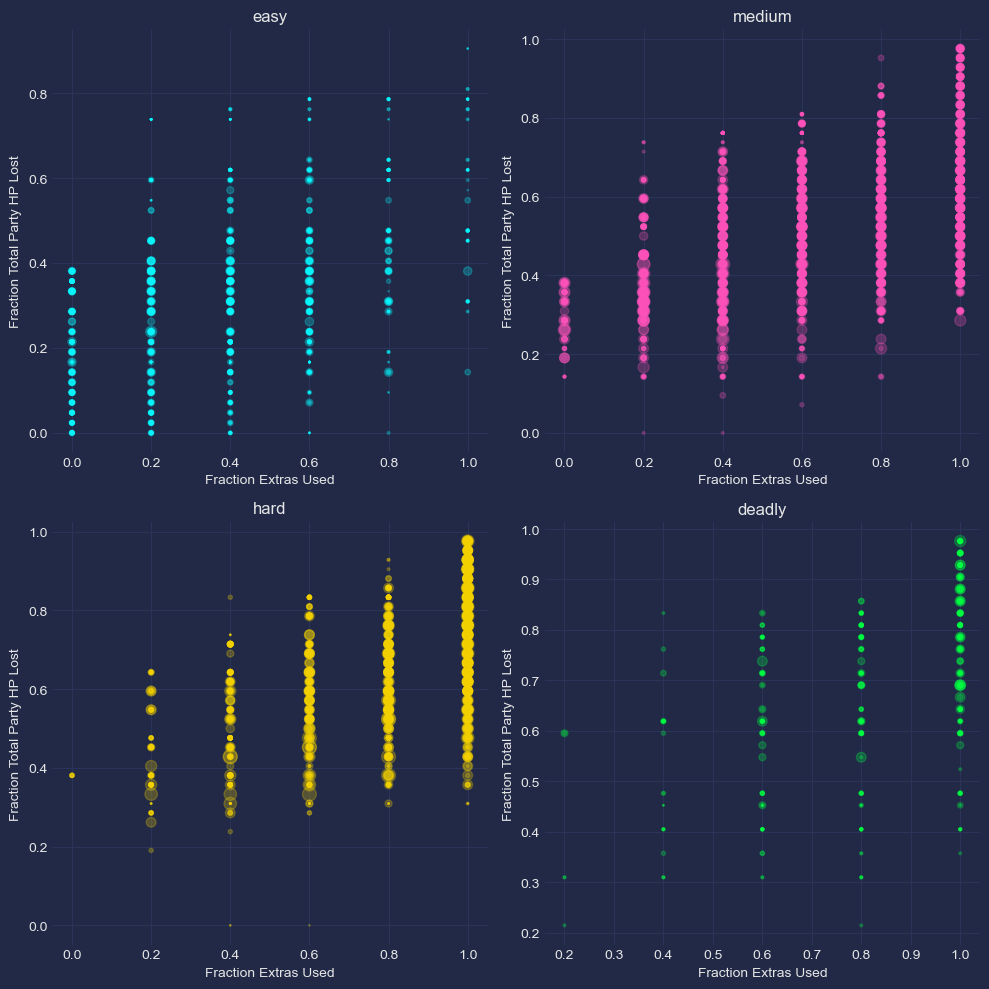

In [16]:
with plt.style.context('cyberpunk'):
    fig,ax=plt.subplots(nrows=2,ncols=2)
    
    fig.set_size_inches(10,10)
    
    ax=ax.ravel()
    
    for idx in range(4):
        ax[idx].set_title(difficulties[idx])
        
        hold_df=wins_df.query(f'difficulty=="{difficulties[idx]}"').copy()
       
        scat=ax[idx].scatter(1-hold_df.frac_party_extras,
                   1-hold_df.frac_party_hp,
                   marker='o',s=hold_df.num_enemies**2,color=colors[idx],
                             alpha=0.25)
        
        ax[idx].set_xlabel('Fraction Extras Used')
        ax[idx].set_ylabel('Fraction Total Party HP Lost')
        
        del hold_df
    
    plt.tight_layout()
    
    plt.savefig('plots/FracHPLost_vs_FracExtrasUsed_ByDifficulty_SizeNumEnemies_4Panel.png')
    
    plt.show()

From the scatter plots above, a few things become clear.  First, with the size of the markers being proporitional to the number of enemies in the encounter squared, we can see that having more enemies doesn't always mean a higher usage of extras and loss of hit points and vice versa.

Second, there is an implied positive correlation between the fraction of extras used and the fraction of total party hit points lost.  However, for deadly encounters, the trend doesn't seem quite as strong.

Third, for medium and hard encounters, there is an implied envelope around the implied correlation, which is narrower for lower values of fraction of extras used and wider for larger fraction of extras used.  This might, however, be due to having a sparsity of points for the lowest fraction of extras used bands.

Following our previous logic, another factor which might control the correlation between our two resources used variables is the number of rounds (or turns) that an encounter takes.  Below, we take a look at the same scatter plots, but with the size of the points proportional to the square of the number of rounds.

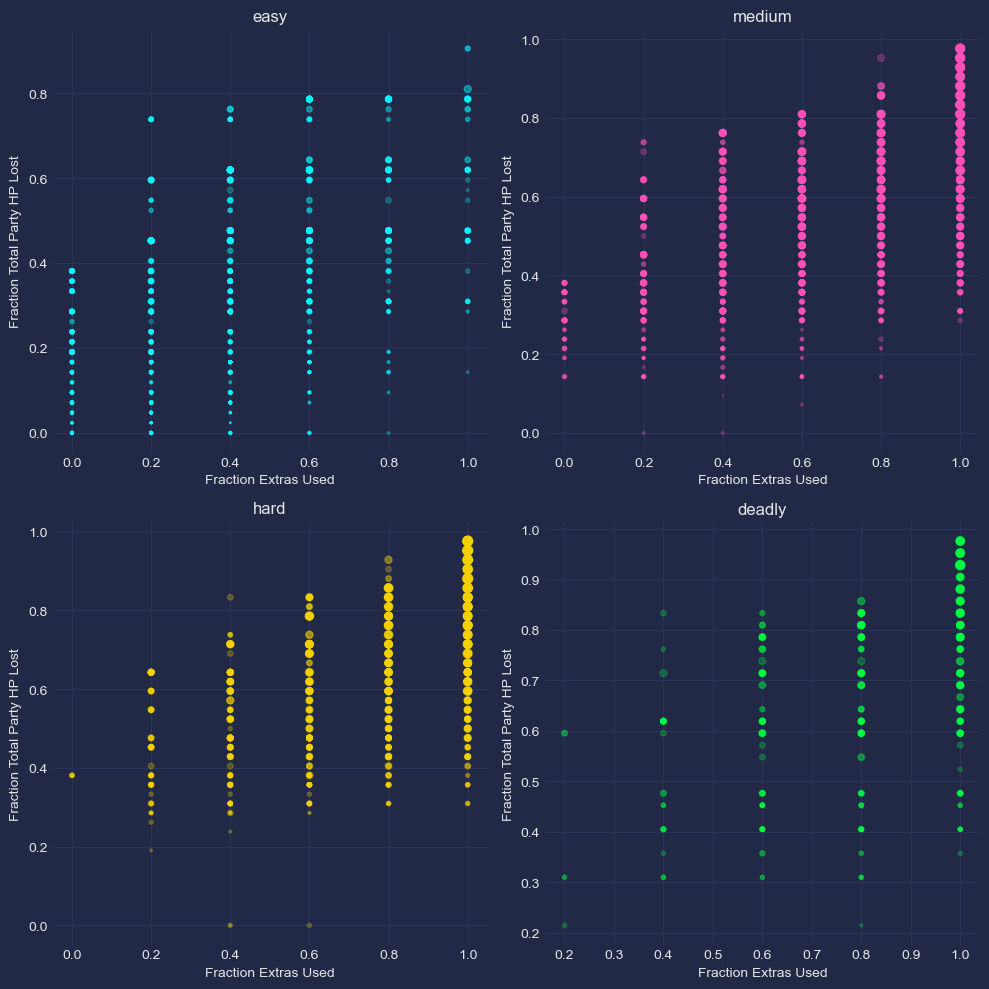

In [17]:
with plt.style.context('cyberpunk'):
    fig,ax=plt.subplots(nrows=2,ncols=2)
    
    fig.set_size_inches(10,10)
    
    ax=ax.ravel()
    
    for idx in range(4):
        ax[idx].set_title(difficulties[idx])
        
        hold_df=wins_df.query(f'difficulty=="{difficulties[idx]}"').copy()
       
        scat=ax[idx].scatter(1-hold_df.frac_party_extras,
                   1-hold_df.frac_party_hp,
                   marker='o',s=hold_df.num_rounds**2,color=colors[idx],
                             alpha=0.25)
        
        ax[idx].set_xlabel('Fraction Extras Used')
        ax[idx].set_ylabel('Fraction Total Party HP Lost')
        
        del hold_df
    
    plt.tight_layout()
    
    plt.savefig('plots/FracHPLost_vs_FracExtrasUsed_ByDifficulty_SizeNumRounds_4Panel.png')
    
    plt.show()

Looking at the scatter plots below, if we pick a particular fraction extras used band, it becomes clear that the total party hit points lost does track well with this variable, particularly for the tougher encounters.  This trend follows what we would expect and tells us that, if we want to evaluate the impact to the party resources, we need a way to gauge how many rounds the encounter is likely to take.

### Indicators of Encounter Length

When exploring if there are any indicators of how long an encounter might take the party, we need to be sure not to use any values which are only known after the encounter has been run or are proxies for the number of rounds.  This rules out any variables relating to the party or enemy resources and the number of turns.  With these considerations, we have num_enemies, CRs, totalXP, and difficulty left.  All four variables are interconnected.

The value of totalXP determines what the difficulty is (or, in the case of how we built the encounters, the desired difficulty determined what possible range of values totalXP could take).  The number of enemies, the challenge ratings, and core rules on multiplicative modifiers using the number of enemies all contribute to the value of totalXP.

How well do totalXP and num\_enemies track the number of rounds for an encounter?  For this question, we can consider all battles, even if they weren't successful, as the higher the totalXP value, the harder the fight and the longer it might take, even if the party loses.

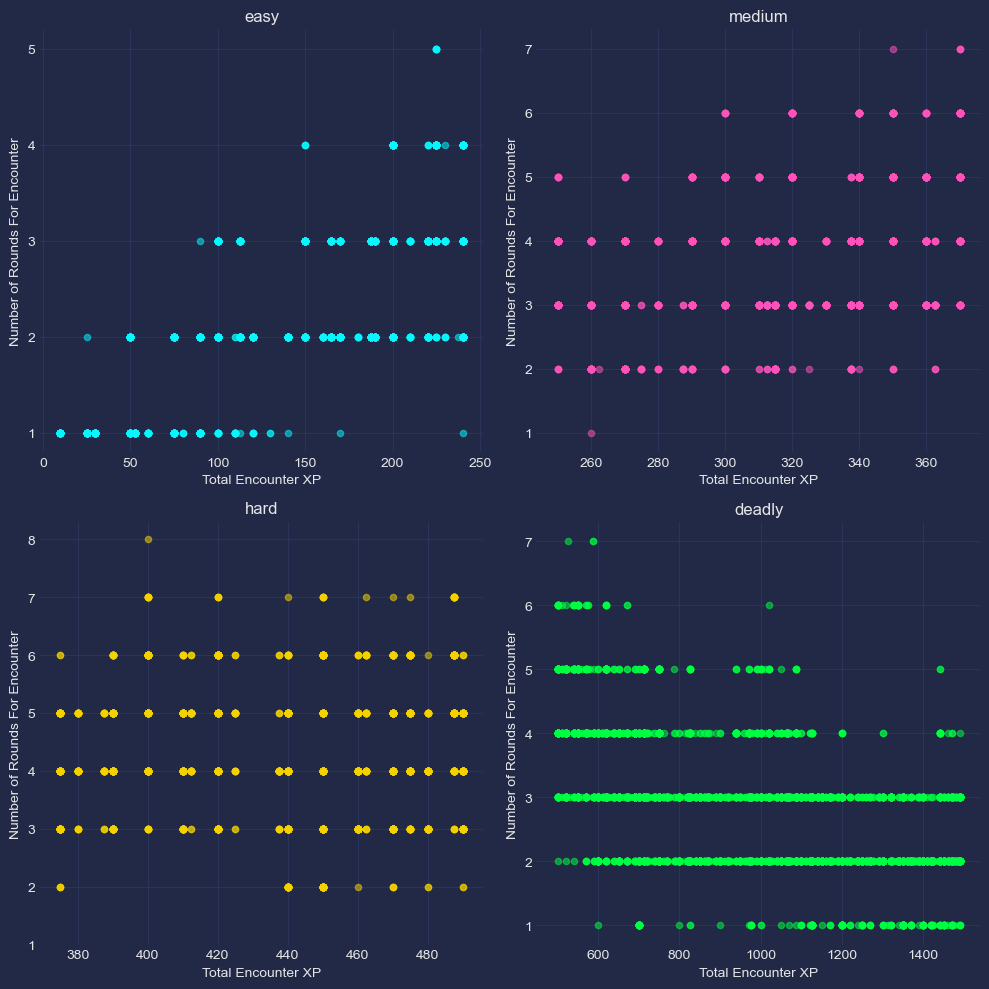

In [18]:
#first, we'll look at totalXP
with plt.style.context('cyberpunk'):
    fig,ax=plt.subplots(nrows=2,ncols=2)
    
    ax=ax.ravel()
    
    fig.set_size_inches(10,10)
    
    for idx in range(4):
        ax[idx].set_title(difficulties[idx])
        
        hold_df=all_df.query(f'difficulty=="{difficulties[idx]}"')
        
        ax[idx].scatter(hold_df.totalXP,hold_df.num_rounds,
                        color=colors[idx],marker='o',s=20,alpha=0.5)
        
        ax[idx].yaxis.set_ticks(ticks=np.arange(1,hold_df.num_rounds.max()+1))
        
        ax[idx].set_xlabel('Total Encounter XP')
        ax[idx].set_ylabel('Number of Rounds For Encounter')
        
        del hold_df
    
    plt.tight_layout()
    
    plt.savefig('plots/NumRounds_vs_TotalXP_ByDifficulty_4Panel.png')
    
    plt.show()

The results are mixed for totalXP.  There is a fairly clear positive trend for easy encounters, but there seems to be no dependence for medium and hard encounters.  For deadly encounters, there is a decidedly negative trend.

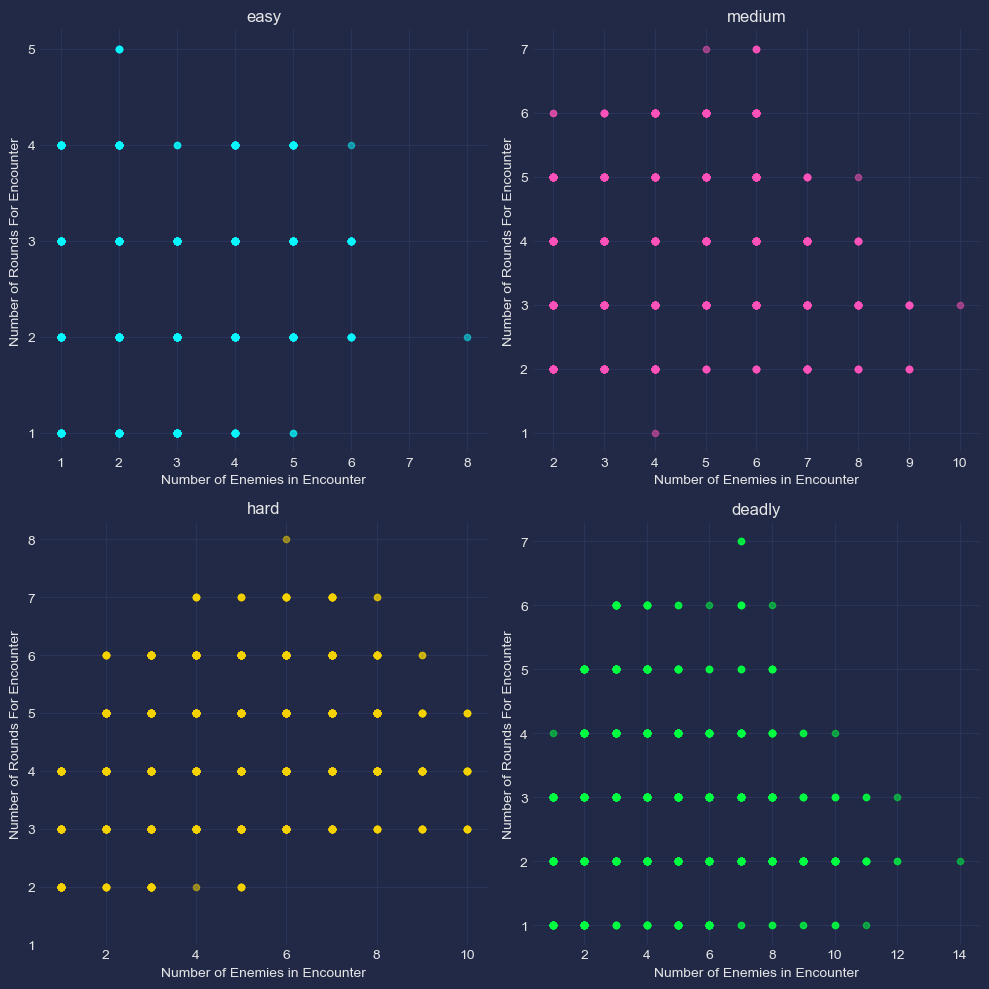

In [19]:
#now we'll take a look at num_enemies
with plt.style.context('cyberpunk'):
    fig,ax=plt.subplots(nrows=2,ncols=2)
    
    ax=ax.ravel()
    
    fig.set_size_inches(10,10)
    
    for idx in range(4):
        ax[idx].set_title(difficulties[idx])
        
        hold_df=all_df.query(f'difficulty=="{difficulties[idx]}"')
        
        ax[idx].scatter(hold_df.num_enemies,hold_df.num_rounds,
                        color=colors[idx],marker='o',s=20,alpha=0.5)
        
        ax[idx].yaxis.set_ticks(ticks=np.arange(1,hold_df.num_rounds.max()+1))
        
        ax[idx].set_xlabel('Number of Enemies in Encounter')
        ax[idx].set_ylabel('Number of Rounds For Encounter')
        
        del hold_df
    
    plt.tight_layout()
    
    plt.savefig('plots/NumRounds_vs_NumEnemies_ByDifficulty_4Panel.png')
    
    plt.show()

When we consider the number of enemies in the encounter, this seems to have little effect for easy and medium encounters.  There may be a positive trend for hard encounters.  For deadly encounters, there doesn't seem to be much of a dependence.

When considering the challenge ratings, we can't simply use the variable as is, since it is a string with the list of challenge ratings. Trying to account for the different, unique combinations is likely more trouble than it is worth, but considering the average challenge rating may be of interest.

In [20]:
from encounter_utils import CR_to_float

def get_ave_CR(S):
        averages=[]
        for val in S.values:
            averages.append(sum([CR_to_float(v) for v in val.split('_')])/len(val.split('_')))
        return averages

In [21]:
more_all_df=pd.concat([all_df,
                       pd.DataFrame({'aveCR':get_ave_CR(all_df.CRs)},index=all_df.index)],
                      axis=1)

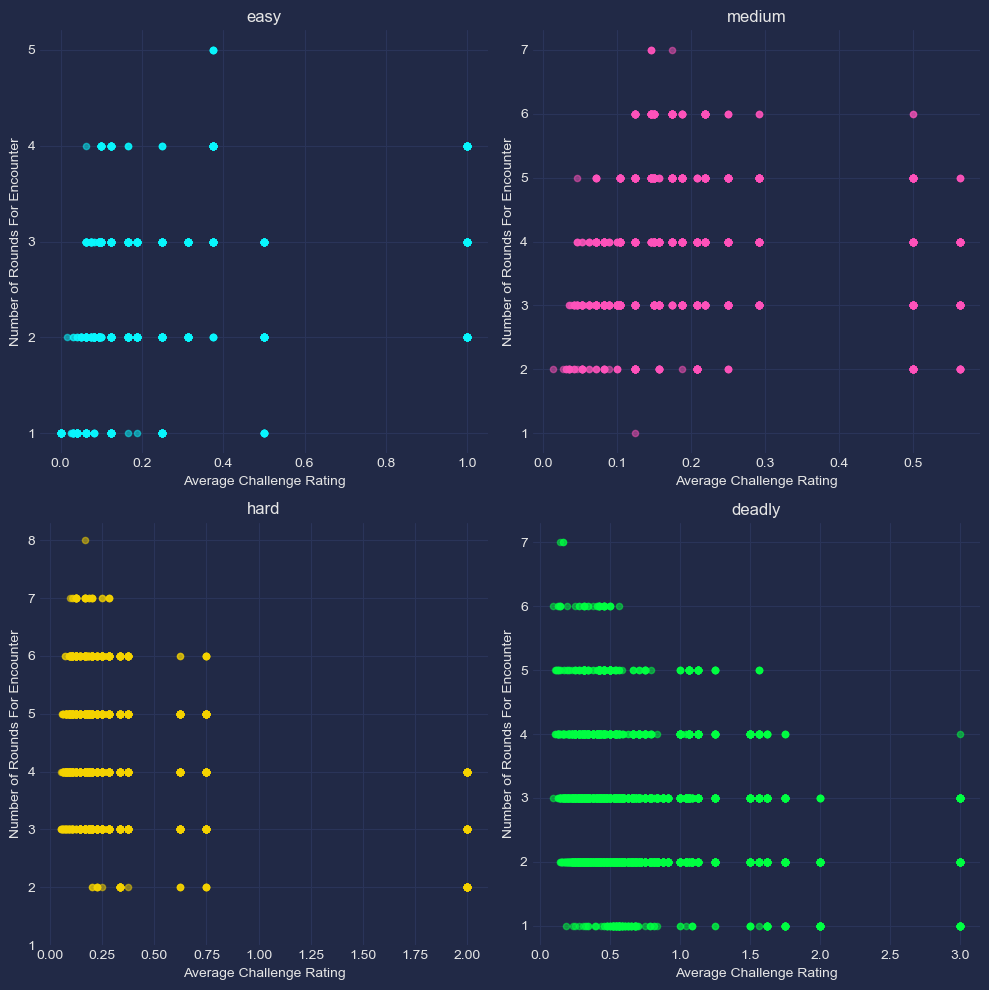

In [22]:
#now we'll take a look at aveCR
with plt.style.context('cyberpunk'):
    fig,ax=plt.subplots(nrows=2,ncols=2)
    
    ax=ax.ravel()
    
    fig.set_size_inches(10,10)
    
    for idx in range(4):
        ax[idx].set_title(difficulties[idx])
        
        hold_df=more_all_df.query(f'difficulty=="{difficulties[idx]}"')
        
        ax[idx].scatter(hold_df.aveCR,hold_df.num_rounds,
                        color=colors[idx],marker='o',s=20,alpha=0.5)
        
        ax[idx].yaxis.set_ticks(ticks=np.arange(1,hold_df.num_rounds.max()+1))
        
        ax[idx].set_xlabel('Average Challenge Rating')
        ax[idx].set_ylabel('Number of Rounds For Encounter')
        
        del hold_df
    
    plt.tight_layout()
    
    plt.savefig('plots/NumRounds_vs_AveCR_ByDifficulty_4Panel.png')
    
    plt.show()

Similar to looking at the number of enemies, the average challenge rating doesn't seem to have a strong role in determining how many rounds the encounter takes.  We can also derive either the total enemy hit points or the average hit points per enemy from the challenge rating scores.  This may have a more direct impact on how many rounds the encounter takes.

In [23]:
from encounter_utils import CR_ave_HP

def get_average_enemy_HP(S):
    averages=[]
    for val in S.values:
        averages.append(sum([CR_ave_HP.get(CR) for CR in val.split('_')])/len(val.split('_')))
    return averages

In [24]:
more_all_df=pd.concat([more_all_df,
                       pd.DataFrame({'ave_enemy_HP':get_average_enemy_HP(all_df.CRs)},index=all_df.index)],
                      axis=1)

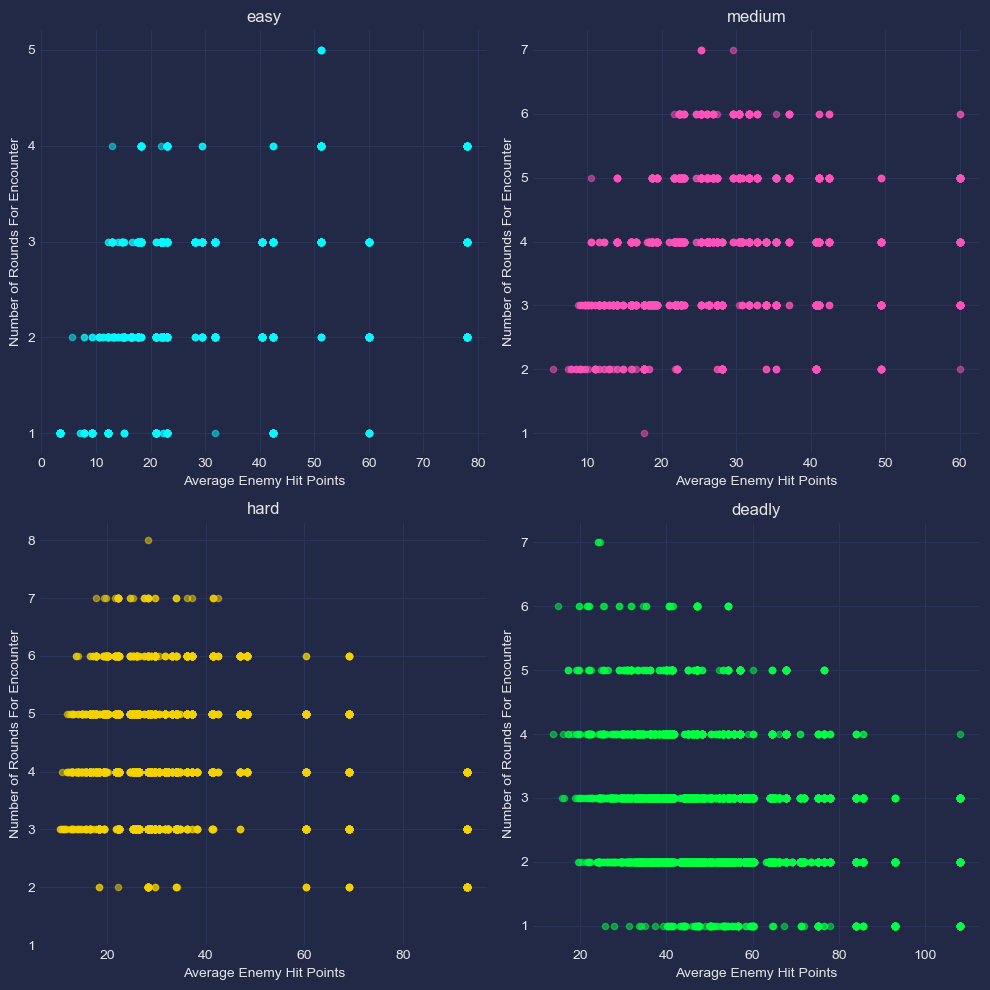

In [25]:
#now we'll take a look at ave_eneme_HP
with plt.style.context('cyberpunk'):
    fig,ax=plt.subplots(nrows=2,ncols=2)
    
    ax=ax.ravel()
    
    fig.set_size_inches(10,10)
    
    for idx in range(4):
        ax[idx].set_title(difficulties[idx])
        
        hold_df=more_all_df.query(f'difficulty=="{difficulties[idx]}"')
        
        ax[idx].scatter(hold_df.ave_enemy_HP,hold_df.num_rounds,
                        color=colors[idx],marker='o',s=20,alpha=0.5)
        
        ax[idx].yaxis.set_ticks(ticks=np.arange(1,hold_df.num_rounds.max()+1))
        
        ax[idx].set_xlabel('Average Enemy Hit Points')
        ax[idx].set_ylabel('Number of Rounds For Encounter')
        
        del hold_df
    
    plt.tight_layout()
    
    plt.savefig('plots/NumRounds_vs_AveEnemyHP_ByDifficulty_4Panel.png')
    
    plt.show()

While the eye can deduce some implied trends, none of them look particularly convincing.  Perhaps it is more important to look at the total enemy hit points?

In [26]:
def get_enemy_HP(S):
    hit_points=[]
    for val in S.values:
        hit_points.append(sum([CR_ave_HP.get(CR) for CR in val.split('_')]))
    return np.round(hit_points)

In [27]:
more_all_df=pd.concat([more_all_df,
                       pd.DataFrame({'enemy_total_HP':get_enemy_HP(all_df.CRs)},index=all_df.index)],
                      axis=1)

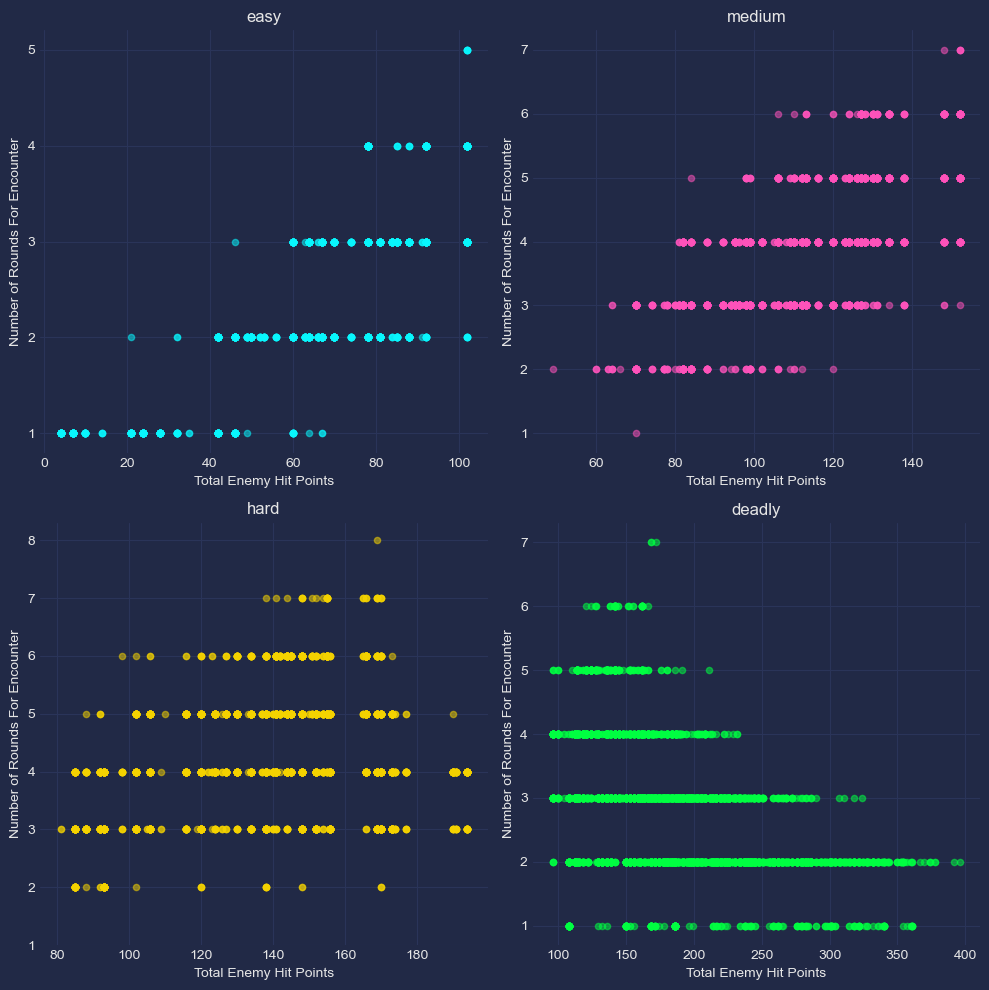

In [28]:
#now we'll take a look at ave_eneme_HP
with plt.style.context('cyberpunk'):
    fig,ax=plt.subplots(nrows=2,ncols=2)
    
    ax=ax.ravel()
    
    fig.set_size_inches(10,10)
    
    for idx in range(4):
        ax[idx].set_title(difficulties[idx])
        
        hold_df=more_all_df.query(f'difficulty=="{difficulties[idx]}"')
        
        ax[idx].scatter(hold_df.enemy_total_HP,hold_df.num_rounds,
                        color=colors[idx],marker='o',s=20,alpha=0.5)
        
        ax[idx].yaxis.set_ticks(ticks=np.arange(1,hold_df.num_rounds.max()+1))
        
        ax[idx].set_xlabel('Total Enemy Hit Points')
        ax[idx].set_ylabel('Number of Rounds For Encounter')
        
        del hold_df
    
    plt.tight_layout()
    
    plt.savefig('plots/NumRounds_vs_TotalEnemyHP_ByDifficulty_4Panel.png')
    
    plt.show()

Things seem to look best with this variable.  Note that the enemy total hit points is a function of challenge rating and number of enemies, though not necessarily a straightforward one, amounting to combining variables.  If we evaluate the correlation coefficients (focusing on just the first column of the correlation matrix below) the correlation with enemy\_total\_HP seems to work for all difficulty categories, but it isn't always the strongest correlation and there are unexpected changes of sign of the correlation for closely related variables.

In [29]:
more_all_df.groupby('difficulty')[['num_rounds','ave_enemy_HP','enemy_total_HP','totalXP','num_enemies','aveCR']].corr()

num_rounds  ave_enemy_HP  enemy_total_HP  totalXP  \
difficulty                                                                     
deadly     num_rounds           1.000        -0.334          -0.380   -0.524   
           ave_enemy_HP        -0.334         1.000          -0.304   -0.057   
           enemy_total_HP      -0.380        -0.304           1.000    0.458   
           totalXP             -0.524        -0.057           0.458    1.000   
           num_enemies         -0.046        -0.759           0.744    0.238   
           aveCR               -0.297         0.922          -0.488   -0.014   
easy       num_rounds           1.000         0.649           0.886    0.842   
           ave_enemy_HP         0.649         1.000           0.669    0.563   
           enemy_total_HP       0.886         0.669           1.000    0.935   
           totalXP              0.842         0.563           0.935    1.000   
           num_enemies          0.239        -0.377           0.344    0.457   
           aveCR                0.592         0.953           0.574    0.559   
hard       num_rounds           1.000        -0.415           0.437   -0.176   
           ave_enemy_HP        -0.415         1.000          -0.491   -0.144   
           enemy_total_HP       0.437        -0.491           1.000    0.007   
           totalXP             -0.176        -0.144           0.007    1.000   
           num_enemies          0.389        -0.876           0.640    0.164   
           aveCR               -0.511         0.949          -0.612   -0.014   
medium     num_rounds           1.000        -0.085           0.761    0.441   
           ave_enemy_HP        -0.085         1.000          -0.098    0.032   
           enemy_total_HP       0.761        -0.098           1.000    0.518   
           totalXP              0.441         0.032           0.518    1.000   
           num_enemies          0.330        -0.877           0.423    0.167   
           aveCR               -0.308         0.901          -0.404    0.027   

                           num_enemies  aveCR  
difficulty                                     
deadly     num_rounds           -0.046 -0.297  
           ave_enemy_HP         -0.759  0.922  
           enemy_total_HP        0.744 -0.488  
           totalXP               0.238 -0.014  
           num_enemies           1.000 -0.752  
           aveCR                -0.752  1.000  
easy       num_rounds            0.239  0.592  
           ave_enemy_HP         -0.377  0.953  
           enemy_total_HP        0.344  0.574  
           totalXP               0.457  0.559  
           num_enemies           1.000 -0.381  
           aveCR                -0.381  1.000  
hard       num_rounds            0.389 -0.511  
           ave_enemy_HP         -0.876  0.949  
           enemy_total_HP        0.640 -0.612  
           totalXP               0.164 -0.014  
           num_enemies           1.000 -0.792  
           aveCR                -0.792  1.000  
medium     num_rounds            0.330 -0.308  
           ave_enemy_HP         -0.877  0.901  
           enemy_total_HP        0.423 -0.404  
           totalXP               0.167  0.027  
           num_enemies           1.000 -0.881  
           aveCR                -0.881  1.000

For now, we can say that the number of rounds tends to scale with either the number of enemies and/or the total enemy hit points, with a weaker dependence for hard encounters and a negative trend for deadly encounters.

### Predicting Encounter Success

While the goal of this project was to derive quantitative metrics to attach to the encounter difficulty categories, an obvious question is whether or not these results can be used to predict which encounters the party will win, or at least derive a reliable propensity estimate.

Logistic regression seems like a good tool to investigate.  For this, instead of using the nominal categories, which we could arguably cast as an ordered category, we will use the total XP for the encounter, since that does map directly to the difficulty category.  For our previous metrics, there is some ambiguity about how to handle edge cases, those encounters just above or below the XP boundary separating two categories.  With this approach, dependent on total XP, that should be handled naturally.

As far as the other variables go, we need to ensure that we only use variables we will have before the encounter is run.  This leaves us with the reasonable choices of num\_enemies, aveCR, and either ave\_enemy\_HP or enemy\_total\_HP.  Of the last two options, only one should be used.  Of the first two, both of these are, as we have discussed, directly related to totalXP.

As a first pass, we will use totalXP, num\_enemies, aveCR, and enemy\_total\_HP.  Given the known interdependency of the variables, we will investigate the use of principal components analysis to derive the features we ultimately feed in to the logistic regression.

In [30]:
#we'll start with the scikit-learn imports
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [31]:
#down select to just the variables we want
logReg_df=more_all_df[['success','num_enemies','aveCR','enemy_total_HP','totalXP']].copy()
logReg_df.success=logReg_df.success.apply(lambda s:1 if s=='Win' else 0).astype('category')

In [32]:
#now, split the data into training and validation
#we'll set the random state for reproducibility
X_train,X_val,Y_train,Y_val=train_test_split(logReg_df.drop(columns='success'),logReg_df.success,test_size=0.2,random_state=7)

In [33]:
#let's make sure that we have reasonable representation of each
#difficulty category
all_df.loc[X_train.index].groupby('difficulty').num_enemies.count()

difficulty
deadly    7956
easy      7995
hard      8030
medium    8019
Name: num_enemies, dtype: int64

In [34]:
#now, we need to scale the variables before attempting PCA so that totalXP does not dominate
scaler=StandardScaler().set_output(transform='pandas')

X_train_scaled=scaler.fit_transform(X_train)

X_val_scaled=scaler.transform(X_val)

In [35]:
#derive the principal components
encounter_pca=PCA().set_output(transform='pandas')

encounter_components=encounter_pca.fit_transform(X_train_scaled)

cumulative_variance=encounter_pca.explained_variance_ratio_.cumsum()

print('\t'.join(encounter_components.columns))
print('\t'.join([f'{cv:.1%}' for cv in cumulative_variance]))

pca0	pca1	pca2	pca3
54.5%	91.5%	96.7%	100.0%


In [36]:
components_df=pd.DataFrame(encounter_pca.components_.T,columns=encounter_components.columns,index=['num_enemies','aveCR','enemy_total_HP','totalXP'])
components_df

,pca0,pca1,pca2,pca3
num_enemies,0.457,-0.552,0.619,3.210e-01
aveCR,0.104,0.779,0.618,-5.446e-04
enemy_total_HP,0.650,-0.009,-0.098,-7.532e-01
totalXP,0.598,0.297,-0.475,5.741e-01


With only two components, we're able to account for just over 90% of the observed variance.

Breaking things down, we can see which variables are important, in which 'directions' to each component.  No obvious 'interpretations' come to mind when looking at the coefficients, so we won't attempt that dubious exercise.

Let's see how things look using just the first two components in the logistic regression.

In [37]:
#first, redo the PCA and transform both the training and validation sets
encounter_pca_2components=PCA(n_components=2).set_output(transform='pandas')

X_train_scaled_pca=encounter_pca_2components.fit_transform(X_train_scaled)

X_val_scaled_pca=encounter_pca_2components.transform(X_val_scaled)

In [38]:
#now we'll see how the classification goes
lr_clf=LogisticRegression(penalty=None)

lr_clf.fit(X_train_scaled_pca,Y_train);

In [39]:
import dmba

In [40]:
dmba.classificationSummary(Y_train,lr_clf.predict(X_train_scaled_pca),class_names=['Lose','Win'])

Confusion Matrix (Accuracy 0.9061)

       Prediction
Actual  Lose   Win
  Lose 10328  1684
   Win  1322 18666


In [41]:
dmba.classificationSummary(Y_val,lr_clf.predict(X_val_scaled_pca),class_names=['Lose','Win'])

Confusion Matrix (Accuracy 0.9099)

       Prediction
Actual Lose  Win
  Lose 2634  437
   Win  284 4645


The model performs very similarly, basd on accuracy, for the training and validation sets, suggesting that overfiting is unlikely, so we won't revisit the choice of ```penalty=None``` when instantiating the LogisticRegression object.  Now we want to investigate if the propensity or perhaps the classification function (detailing the odds of winning) seems like a better prediction to report.  Predicting "Win" or "Lose" is likely too precise given the assumptions and simplifications which have gone into our simulation.  Additionally, the player creativity factor may completely throw those predictions, whereas predicting the odds of the party winning the encounter may provide a dungeon master with a better sense of the potential outcome.

For the odds, we can use the intercept and coefficients of the logistic regression model:

Odds = $e^{\beta_{0} + \sum_{i = 1}^{2} \beta_{i} pca_{i-1} }$

In [42]:
lr_intercept=lr_clf.intercept_[0]
lr_coeff0=lr_clf.coef_[0][0]
lr_coeff1=lr_clf.coef_[0][1]

In [43]:
print(f'Odds equation is exp{{{lr_intercept:.2f} {lr_coeff0:+.2f}*pca0 {lr_coeff1:+.2f}*pca1}}')

Odds equation is exp{0.88 -3.96*pca0 -1.63*pca1}


In [44]:
Odds_train=np.exp(lr_intercept+lr_coeff0*X_train_scaled_pca.pca0+lr_coeff1*X_train_scaled_pca.pca1)
Odds_val=np.exp(lr_intercept+lr_coeff0*X_val_scaled_pca.pca0+lr_coeff1*X_val_scaled_pca.pca1)

In [45]:
new_odds_val=lr_clf.predict_proba(X_val_scaled_pca)[:,1]/(1-lr_clf.predict_proba(X_val_scaled_pca)[:,1])

Let's take a look at how the odds look for successful and unsuccessful encounters in the validation set.  Given the large range of odds values, we'll actually use the log(odds) for plotting purposes.  To keep this in perspective, note that a log(odds) value of zero (denoted by the green, vertical line) is even odds, a 50/50 win or lose prediction.

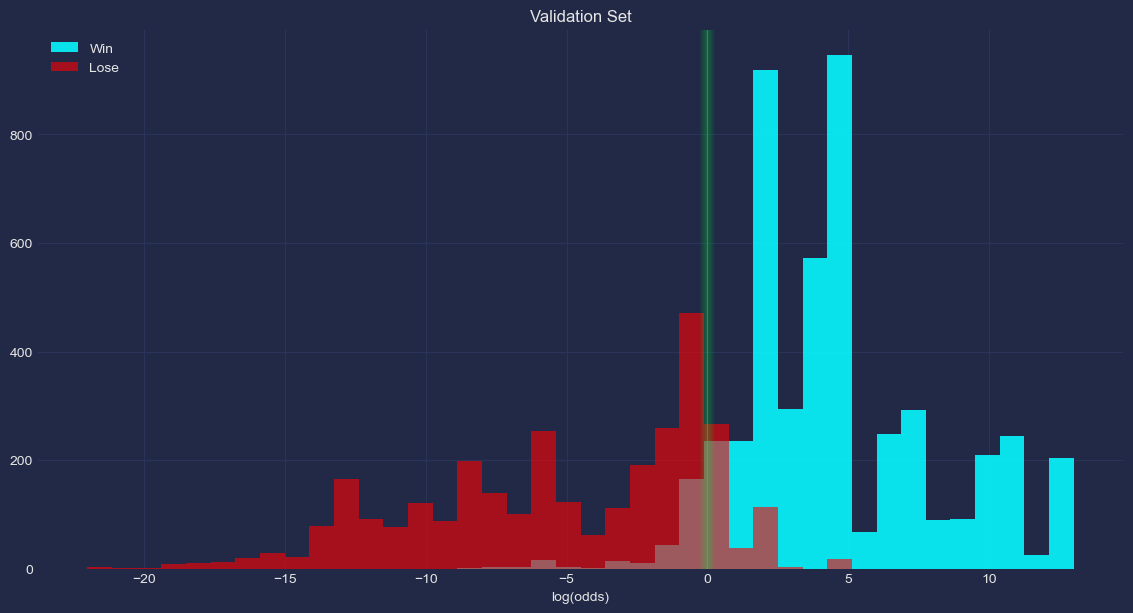

In [46]:
with plt.style.context('cyberpunk'):
    fig,ax=plt.subplots()
    
    fig.set_size_inches(h=7,w=14)
    
    #given the vast range of values, we'll use bins of equal size in log space
    #and consider the log(odds)
    #we have 8000 points in the validation set, let's try for 40 bins
    
    odds_bins=(np.linspace(np.floor(np.log(Odds_val.min())),np.ceil(np.log(Odds_val.max())),41))
    
    h_win=ax.hist(np.log(Odds_val.loc[Y_val==1]),odds_bins,color='C0',label='Win',alpha=0.9)
    
    h_lose=ax.hist(np.log(Odds_val.loc[Y_val==0]),odds_bins,color='C4',label='Lose',alpha=0.6)
    
    vline=ax.axvline(0,color='C3',alpha=0.5,linewidth=0.5)
    
    mplcyberpunk.make_lines_glow(lines=vline)
    
    ax.legend(loc='upper left')
        
    ax.set_xlabel('log(odds)')
    
    ax.set_title('Validation Set')
    
    plt.savefig('plots/LogOdds_Validation_WinVsLose.png')
    
    plt.show()

This looks fairly reasonable, and we can see the the majority of encounters with predicted odds < 1 (or log(odds) < 0) do correspond to lost encounters.  The percentage of encounters odds < 1 encounters the PCs actually won (false negatives) is 284/2918 x 100% = 9.7%.  This is in line with the overall accuracy of the prediction, but any good DM knows that just because the odds of the PCs winning are 1 in 4 (odds = 0.25) doesn't mean that the players won't pull out some incredibly crazy, lucky plays.  Similarly, just because the odds are 4 to 1 that the players will win doesn't mean some unlucky rolls on their part or poor, spur of the moment decisions won't lead them to losing.

We've convinced ourselves, for now, that a model which returns the odds of winning is better than a straight up win-lose prediction.  The next big question is, how does the predictive accuracy fall out when we split the data along the difficulty categories?  For this, we will similarly focus on just the validation set.

In [47]:
easy_index=all_df.loc[X_val.index].query('difficulty=="easy"').index
medium_index=all_df.loc[X_val.index].query('difficulty=="medium"').index
hard_index=all_df.loc[X_val.index].query('difficulty=="hard"').index
deadly_index=all_df.loc[X_val.index].query('difficulty=="deadly"').index

In [48]:
print('For easy encounters:')
dmba.classificationSummary(Y_val.loc[easy_index],lr_clf.predict(X_val_scaled_pca.loc[easy_index]),class_names=['Lose','Win'])

For easy encounters:
Confusion Matrix (Accuracy 0.9910)

       Prediction
Actual Lose  Win
  Lose    0   18
   Win    0 1987


In [49]:
print('For medium encounters:')
dmba.classificationSummary(Y_val.loc[medium_index],lr_clf.predict(X_val_scaled_pca.loc[medium_index]),class_names=['Lose','Win'])

For medium encounters:
Confusion Matrix (Accuracy 0.9268)

       Prediction
Actual Lose  Win
  Lose    1  123
   Win   22 1835


In [50]:
print('For hard encounters:')
dmba.classificationSummary(Y_val.loc[hard_index],lr_clf.predict(X_val_scaled_pca.loc[hard_index]),class_names=['Lose','Win'])

For hard encounters:
Confusion Matrix (Accuracy 0.7766)

       Prediction
Actual Lose  Win
  Lose  741  285
   Win  155  789


In [51]:
print('For deadly encounters:')
dmba.classificationSummary(Y_val.loc[deadly_index],lr_clf.predict(X_val_scaled_pca.loc[deadly_index]),class_names=['Lose','Win'])

For deadly encounters:
Confusion Matrix (Accuracy 0.9423)

       Prediction
Actual Lose  Win
  Lose 1892   11
   Win  107   34


As one might have feared would happen, the predictions aren't great for the individual encounters difficulty categories.  For easy encounters, we always predict win, with so few lose instances, this doesn't result in much loss of accuracy.  For medium encounters, we predict win more often than lose, but most of the actual lost encounters are predicted to win, with again little impact on accuracy.  For the hard encounters, the predictions are a bit better, performing almost equally well on actual wins and loses with a reduction in accuracy.  For deadly encounters, we swing the other direction, hardly ever predicting a win which still results in high accuracy.  This is a case where even though we checked stratification along the difficulties, the lose and win instances had unequal representation among them, so maybe accuracy isn't the best best.

However, we have decided that returning odds is a better approach than a win-lose prediction.  How do the log(odds) histograms look for the different difficulty categories?

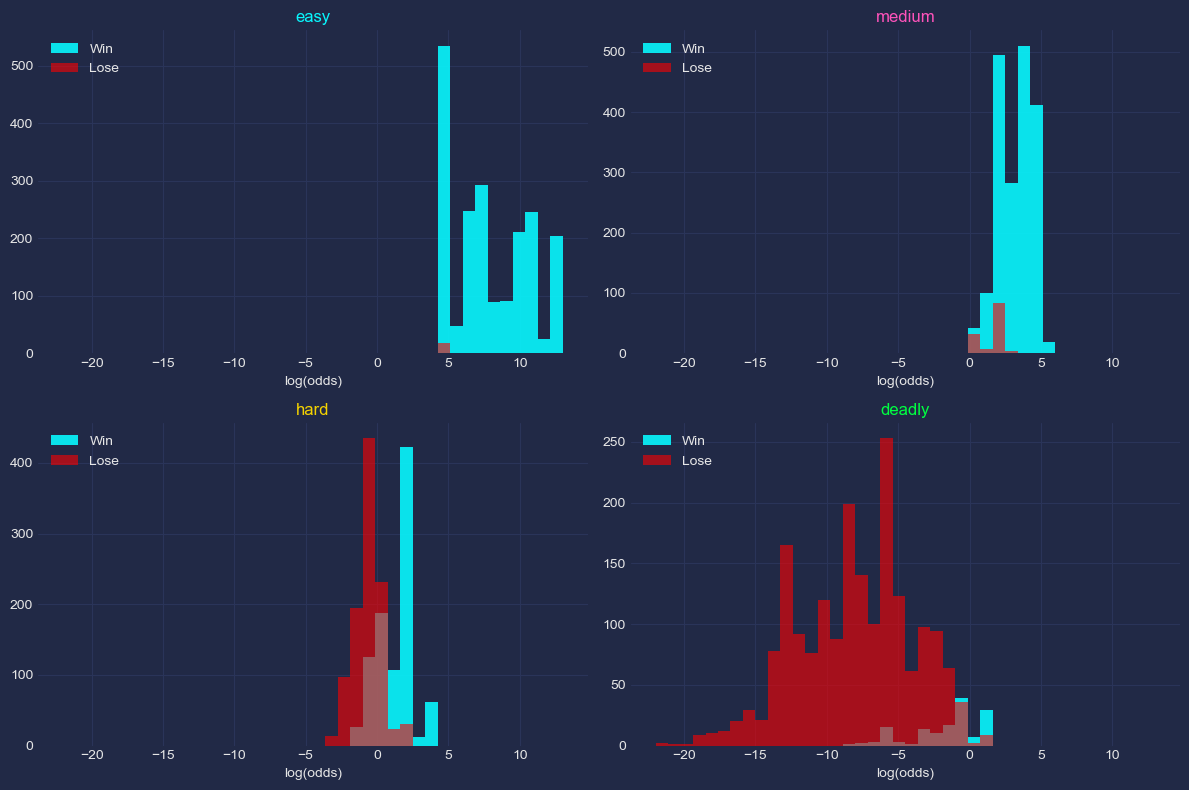

In [52]:
with plt.style.context('cyberpunk'):
    fig,ax=plt.subplots(nrows=2,ncols=2)
    
    ax=ax.ravel()
    
    fig.set_size_inches(h=8,w=12)
    
    #given the vast range of values, we'll use bins of equal size in log space
    #and consider the log(odds)
    #we have 8000 points in the validation set, let's try for 40 bins
    
    odds_bins=(np.linspace(np.floor(np.log(Odds_val.min())),np.ceil(np.log(Odds_val.max())),41))
    
    d_index={'easy':easy_index,
             'medium':medium_index,
             'hard':hard_index,
             'deadly':deadly_index}
    
    
    for idx,difficulty in enumerate(difficulties):
        ax[idx].set_title(difficulty,color=colors[idx])
        
        h_win=ax[idx].hist(np.log(Odds_val.loc[d_index[difficulty]].loc[Y_val==1]),odds_bins,color='C0',label='Win',alpha=0.9)
    
        h_lose=ax[idx].hist(np.log(Odds_val.loc[d_index[difficulty]].loc[Y_val==0]),odds_bins,color='C4',label='Lose',alpha=0.6)
        
        ax[idx].legend(loc='upper left')
        
        ax[idx].set_xlabel('log(odds)')
    
    plt.tight_layout()
    
    plt.savefig('plots/LogOdds_Validation_WinVsLose_ByDifficulty_4Panel.png')
    
    plt.show()

With the party starting at full health and with all extras, it intuitively makes sense that the odds would always be in their favor for an easy or medium encounter.  For a hard encounter, it seems to be a toss up whether or not odds are in the party's favor.  For a deadly encounter, the odds are most frequently against the party, but possibly too much against them.  This may be due to the logic used to construct a deadly encounter in our simulations and it may be interesting to look at odds vs number of enemies (e.g., do the odds go down with increased number of enemies, particularly for a deadly encounter).

Having switched to principal components instead of the original features, the reasoning behind the derived odds values are likely to seem opaque, so 'profiling' the results in this manner is likely a good approach.

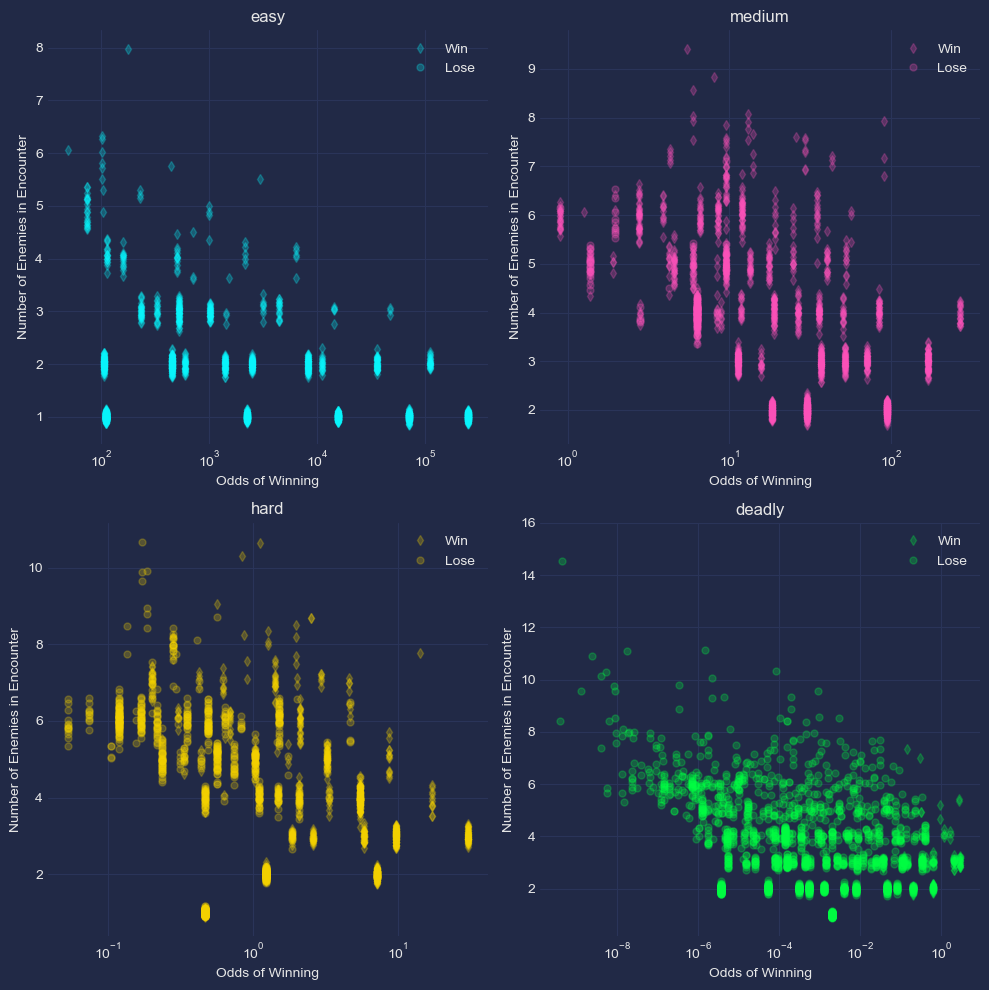

In [53]:
with plt.style.context('cyberpunk'):
    fig,ax=plt.subplots(nrows=2,ncols=2)
    
    fig.set_size_inches(10,10)
    
    ax=ax.ravel()
    
    for idx in range(4):
        ax[idx].set_title(difficulties[idx])
        
        #we could probably clean up these two calls to the plot method
        ax[idx].plot(Odds_val.loc[d_index[difficulties[idx]]].loc[Y_val==1],
                     all_df.loc[d_index[difficulties[idx]]].loc[Y_val==1].num_enemies*np.random.normal(1,0.05,size=len(all_df.loc[d_index[difficulties[idx]]].loc[Y_val==1].num_enemies)),
                     marker='d',ms=5,color=colors[idx],linestyle='none',
                     label='Win',alpha=0.25)
        
        ax[idx].plot(Odds_val.loc[d_index[difficulties[idx]]].loc[Y_val==0],
                     all_df.loc[d_index[difficulties[idx]]].loc[Y_val==0].num_enemies*np.random.normal(1,0.05,size=len(all_df.loc[d_index[difficulties[idx]]].loc[Y_val==0].num_enemies)),
                     marker='o',ms=5,color=colors[idx],linestyle='none',
                     label='Lose',alpha=0.25)
        
        #given the large range of values, need a log scale
        ax[idx].set_xscale('log')
        
        ax[idx].set_xlabel('Odds of Winning')
        ax[idx].set_ylabel('Number of Enemies in Encounter')
        
        ax[idx].legend(loc='upper right')
    
    #retroactively make a slight adjustment to the deadly encounter plot
    ax[3].yaxis.set_ticks(ticks=np.arange(2,18,2))
    
    plt.tight_layout()
    
    plt.savefig('plots/NumEnemies_vs_Odds_ByDifficulty_4Panel.png')
    
    plt.show()

There is a clear negative trend between the number of enemies in the encounter and the odds of winning.  Note that we have jittered the y-axis of the points slightly in an attempt to discern overlapping points better given that the num\_enemies variable is quantized.  A deadly encounter with 10 or more enemies is quite likely to have low odds for a party of 5 first level PCs (and a dungeon master is unlikely to create such an encounter unless they are thinking "and this is how the party gets captured" or something similar).  There are, of course, outliers to the general trends, but overall the implications are interesting.

Let's see how these same scatter plots look for the other variables we used to construct our principal components.

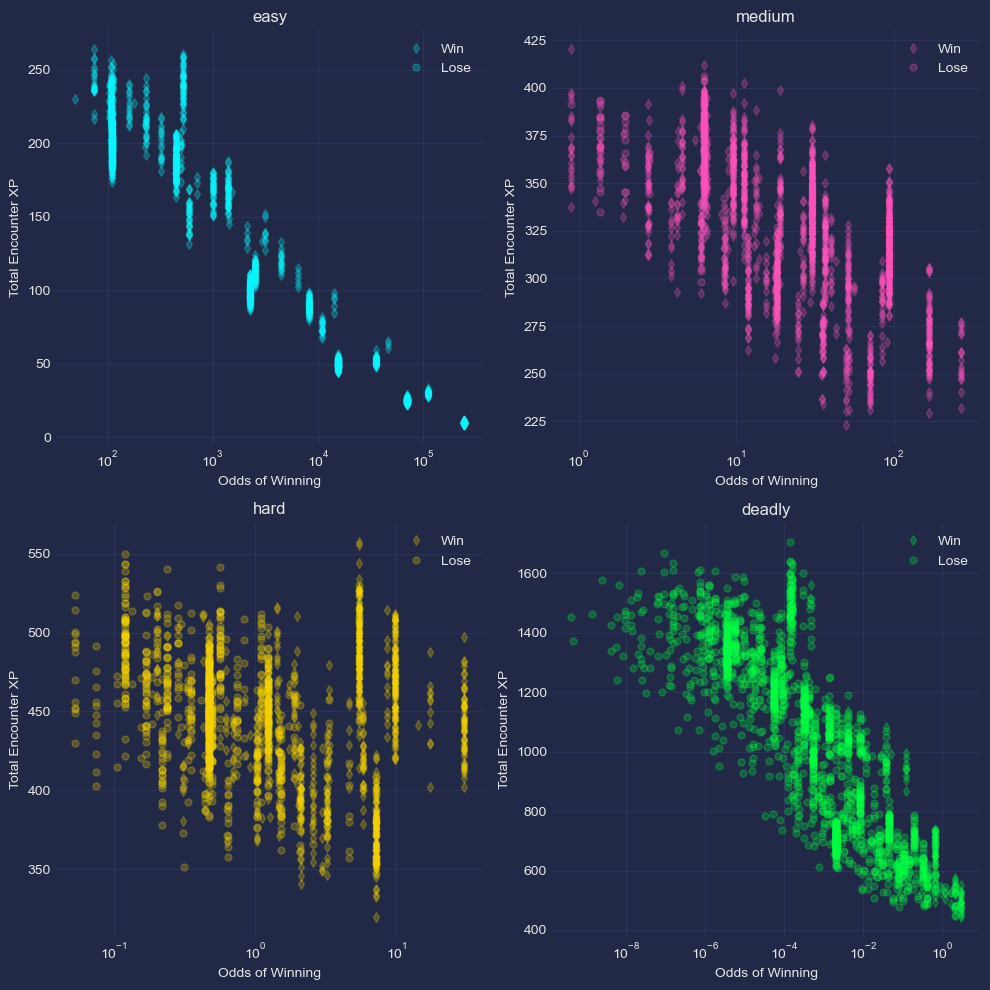

In [54]:
with plt.style.context('cyberpunk'):
    fig,ax=plt.subplots(nrows=2,ncols=2)
    
    fig.set_size_inches(10,10)
    
    ax=ax.ravel()
    
    for idx in range(4):
        ax[idx].set_title(difficulties[idx])
        
        #we could probably clean up these two calls to the plot method
        ax[idx].plot(Odds_val.loc[d_index[difficulties[idx]]].loc[Y_val==1],
                     all_df.loc[d_index[difficulties[idx]]].loc[Y_val==1].totalXP*np.random.normal(1,0.05,size=len(all_df.loc[d_index[difficulties[idx]]].loc[Y_val==1].totalXP)),
                     marker='d',ms=5,color=colors[idx],linestyle='none',
                     label='Win',alpha=0.25)
        
        ax[idx].plot(Odds_val.loc[d_index[difficulties[idx]]].loc[Y_val==0],
                     all_df.loc[d_index[difficulties[idx]]].loc[Y_val==0].totalXP*np.random.normal(1,0.05,size=len(all_df.loc[d_index[difficulties[idx]]].loc[Y_val==0].totalXP)),
                     marker='o',ms=5,color=colors[idx],linestyle='none',
                     label='Lose',alpha=0.25)
        
        #given the large range of values, need a log scale
        ax[idx].set_xscale('log')
        
        ax[idx].set_xlabel('Odds of Winning')
        ax[idx].set_ylabel('Total Encounter XP')
        
        ax[idx].legend(loc='upper right')
    
    plt.tight_layout()
    
    plt.savefig('plots/TotalXP_vs_Odds_ByDifficulty_4Panel.png')
    
    plt.show()

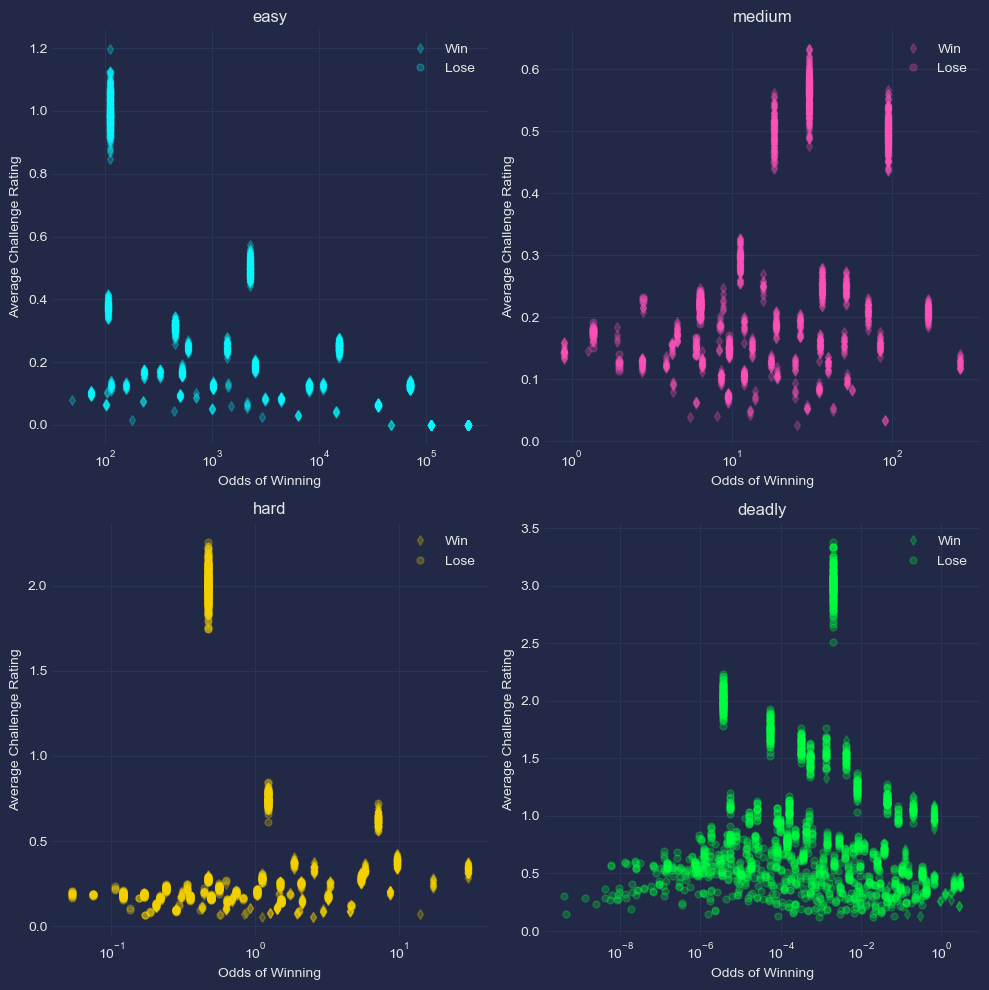

In [55]:
with plt.style.context('cyberpunk'):
    fig,ax=plt.subplots(nrows=2,ncols=2)
    
    fig.set_size_inches(10,10)
    
    ax=ax.ravel()
    
    for idx in range(4):
        ax[idx].set_title(difficulties[idx])
        
        #we could probably clean up these two calls to the plot method
        ax[idx].plot(Odds_val.loc[d_index[difficulties[idx]]].loc[Y_val==1],
                     X_val.loc[d_index[difficulties[idx]]].loc[Y_val==1].aveCR*np.random.normal(1,0.05,size=len(X_val.loc[d_index[difficulties[idx]]].loc[Y_val==1].aveCR)),
                     marker='d',ms=5,color=colors[idx],linestyle='none',
                     label='Win',alpha=0.25)
        
        ax[idx].plot(Odds_val.loc[d_index[difficulties[idx]]].loc[Y_val==0],
                     X_val.loc[d_index[difficulties[idx]]].loc[Y_val==0].aveCR*np.random.normal(1,0.05,size=len(X_val.loc[d_index[difficulties[idx]]].loc[Y_val==0].aveCR)),
                     marker='o',ms=5,color=colors[idx],linestyle='none',
                     label='Lose',alpha=0.25)
        
        #given the large range of values, need a log scale
        ax[idx].set_xscale('log')
        
        ax[idx].set_xlabel('Odds of Winning')
        ax[idx].set_ylabel('Average Challenge Rating')
        
        ax[idx].legend(loc='upper right')
    
    plt.tight_layout()
    
    plt.savefig('plots/AveCR_vs_Odds_ByDifficulty_4Panel.png')
    
    plt.show()

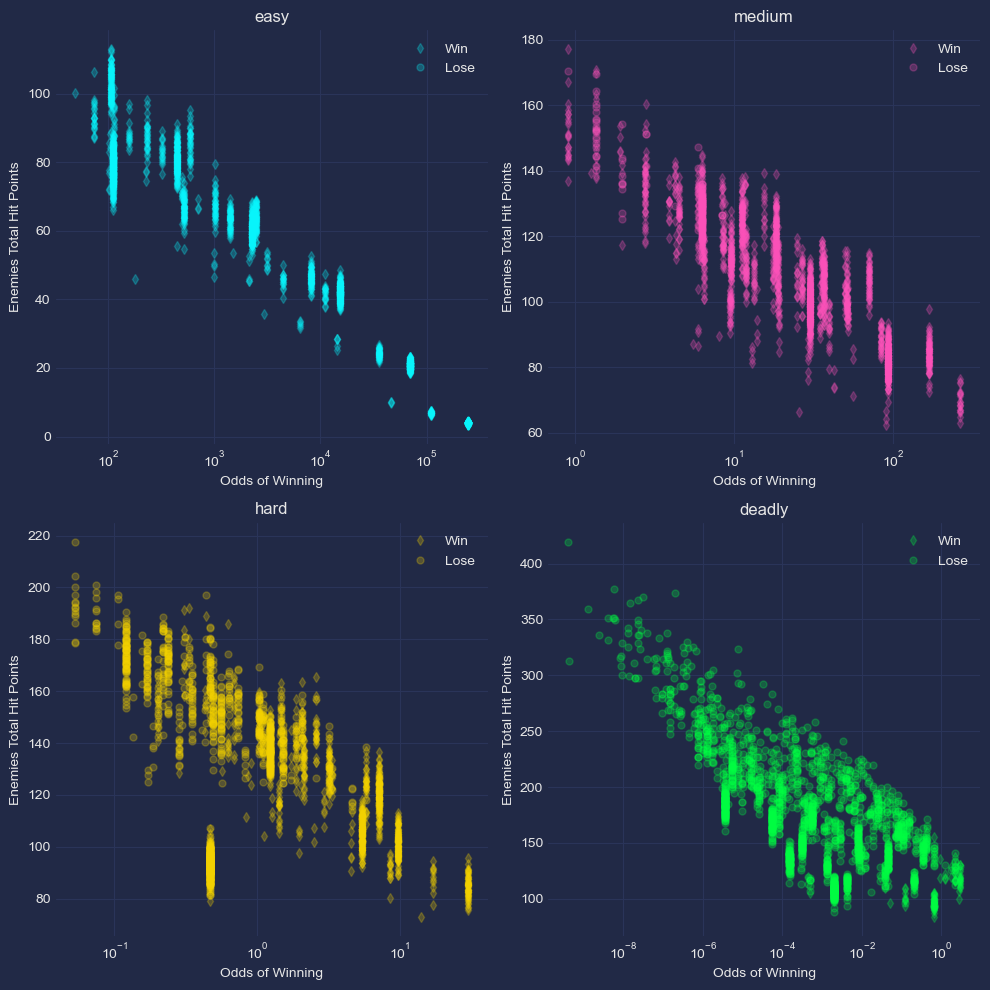

In [56]:
with plt.style.context('cyberpunk'):
    fig,ax=plt.subplots(nrows=2,ncols=2)
    
    fig.set_size_inches(10,10)
    
    ax=ax.ravel()
    
    for idx in range(4):
        ax[idx].set_title(difficulties[idx])
        
        #we could probably clean up these two calls to the plot method
        ax[idx].plot(Odds_val.loc[d_index[difficulties[idx]]].loc[Y_val==1],
                     X_val.loc[d_index[difficulties[idx]]].loc[Y_val==1].enemy_total_HP*np.random.normal(1,0.05,size=len(X_val.loc[d_index[difficulties[idx]]].loc[Y_val==1].enemy_total_HP)),
                     marker='d',ms=5,color=colors[idx],linestyle='none',
                     label='Win',alpha=0.25)
        
        ax[idx].plot(Odds_val.loc[d_index[difficulties[idx]]].loc[Y_val==0],
                     X_val.loc[d_index[difficulties[idx]]].loc[Y_val==0].enemy_total_HP*np.random.normal(1,0.05,size=len(X_val.loc[d_index[difficulties[idx]]].loc[Y_val==0].enemy_total_HP)),
                     marker='o',ms=5,color=colors[idx],linestyle='none',
                     label='Lose',alpha=0.25)
        
        #given the large range of values, need a log scale
        ax[idx].set_xscale('log')
        
        ax[idx].set_xlabel('Odds of Winning')
        ax[idx].set_ylabel('Enemies Total Hit Points')
        
        ax[idx].legend(loc='upper right')
    
    plt.tight_layout()
    
    plt.savefig('plots/TotalEnemyHP_vs_Odds_ByDifficulty_4Panel.png')
    
    plt.show()

The variables giving the total enemy hit points and the total encounter XP track the odds of winning with a similar negative trend as the number of enemies.  Interestingly, the average challenge rating does not display a clear trend vs the odds of winning.  This variable is the most important for the second principal component, which accounts for 37% of the observed variance, so we think it still makes sense to keep it in the analysis.

The total enemy hit points may have the clearest trend vs. odds of winning.  Additionally, comparing the location of wins (diamonds) and losses (circles) graphically, the total enemy hit points varaible may also provide the clearest separation.

### Current Conclusions

We have used simple simulations, contingent upon the assumptions discussed in the README, to produce quantitative metrics regarding the encounter difficulty categories.  These can be useful for dungeon masters planning a multi-encounter scenario and wanting to better understand how the different encounters might affect party resources, and, thus, if the scenario is too ambitious.  While we have cast these metrics primarily in terms of resources used to win an encounter, on average, the dungeon master will need to factor in if the party has resources not accounted for in our simulations and which resources the party is able to regain (e.g., via a short rest).

We have also demonstrated that, using only variables the dungeon master would have access to before the encounter is run, we can produce reasonable odds of winning via principal components analysis and logistic regression.  These odds may not be accurate when players have significantly more or less 'extras' than our simulations have assumed, or when other considerations should alter the difficulty category of the encounter (un/favorable terrain, a well-planned ambush by either side in the battle, etc.).

These conclusions (metrics, predicted odds of winning) are all contingent upon the validity of the assumptions and simplifications which are built into the simulations.  Further, we have not yet verified how these conclusions generalize to different numbers of PCs or to higher levels.  Ideally, we will investigate these questions in the future, though we do not attempt to provide any timeline estimates.

Constructive feedback is welcomed and encouraged.  Tabletop gaming can instill passionate opinions in people, and we make no claim that our assumptions or treatment is definitive or absolutely correct.  Rather, this is one perspective, aimed at having fun with data analysis and D&D.

The trained standard scaler, PCA analysis, and logistic regression classifier are included with the repo in a pickled file (see code below).

In [57]:
import joblib

with open('outputs/classifier_objects.pkl','wb') as outfile:
    joblib.dump((scaler,encounter_pca,lr_clf),outfile)